In [267]:
# Use "SVD" to predict user rating of each movie

In [268]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn
import re
import itertools
from collections import Counter
from collections import defaultdict
import gzip
import struct
import smtplib
from email.mime.text import MIMEText
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

In [269]:
basedir = '/home/tvromen/research/subtitles'

class Flags(object):
    def __init__(self):
        # Data loading params
        self.val_sample_percentage = .1 # Percentage of the training data to use for validation
        self.ratings_file = os.path.join(basedir, 'ml-20m/ratings.csv') # Data source for the ratings
        self.text_data_file = os.path.join(basedir, 'movielens-subtitles-1024.txt') # Data source

        self.max_lines = 100000

        # Model Hyperparameters
        self.embedding_dim = 64 # Dimensionality of user & movie vectors (default: 128)

        #self.max_vocab_size = 100000
        #self.vocab_embedding_dim = 300 # Dimensionality of character embedding (default: 128)
        #self.filter_sizes = "3,4,5" # Comma-separated filter sizes (default: '3,4,5')
        #self.num_filters = 128 # Number of filters per filter size (default: 128)
        #self.dropout_keep_prob = 0.5 # Dropout keep probability (default: 0.5)

        #self.words_in_scene = 64
        #self.num_scenes = 16

        # Training parameters
        self.batch_size = 128 # Batch Size (default: 128)
        self.num_epochs = 10 # Number of training epochs (default: 8)
        self.summary_every = 100
        self.evaluate_every = 1000 # Evaluate model on val set after this many steps (default: 100)
        self.checkpoint_every = 2000 # Save model after this many steps (default: 100)
        self.num_checkpoints = 3 # Number of checkpoints to store (default: 5)
        # Misc Parameters
        self.allow_soft_placement = True # Allow device soft device placement
        self.log_device_placement = True # Log placement of ops on devices

FLAGS = Flags()

In [279]:
# Data helpers

class IdAssigner:
    def __init__(self):
        self.forward = dict()
        self.reverse = dict()
        self.next_id = 0
    def get_id(self, x):
        if x not in self.forward:
            self.forward[x] = self.next_id
            self.reverse[self.next_id] = x
            self.next_id += 1
        return self.forward[x]
    def get_reverse_id(self, id_):
        return self.reverse[id_]
    def get_next_id(self):
        return self.next_id

class Subtitles:
    """
    Class that is in charge of subtitles
    """
    def __init__(self, data_file):
        samples = list(open(data_file, 'r').readlines())
        samples = [s.strip() for s in samples]
        ids = [int(s.split()[0]) for s in samples]
        x_text = [' '.join(s.split()[1:]) for s in samples]
        self.subs = dict()
        for id_,txt in zip(ids, x_text):
            self.subs[id_] = txt


class RatingsData:
    """
    Loads the ratings from the file. Returns an array x where each row is [user_id, movie_id]
    The movie_id is not the original movie_id, but rather a new id which is allocated densely (no skips)
    Only movies with rating >= 3.0 are considered watched (TODO)
    """

    def __init__(self, data_file, max_lines, subs):
        self.id_assigner = IdAssigner()
        self.movies_per_user = defaultdict(list) # map user_id -> [movie_id_1, movie_id_2, ...]
        self.movie_watch_count = defaultdict(int)   # number of times watched per new_movie_id
        # load file
        x = self._load_file(data_file, max_lines, subs)
        x = self._sort_dataset(x)
        x = x[['user_id', 'movie_id', 'rating']]
        # split training/validation:
        # the training set is all movies for each user except the last (in chronological order)
        # validation set is the last movie for each user
        user_ids = x['user_id']
        is_last = (user_ids != np.append(user_ids[1:], -1))
        self.train = x[~is_last]
        self.val = x[is_last]

    def _load_file(self, data_file, max_lines, subs):
        print("Loading data...")
        x = np.zeros(
            max_lines,
            dtype=[('valid',np.bool), ('user_id',np.int32), ('movie_id', np.int32), ('rating', np.float32), ('timestamp', np.int32)]
        )
        with open(data_file) as f:
            _ = f.readline() # skip first line
            for i,line in enumerate(f.readlines()):
                if i % 1000000 == 0:
                    print('{}...'.format(i))
                if i == max_lines:
                    break
                words = line.split(',')
                user_id  = int(words[0])
                movie_id = int(words[1])
                rating   = float(words[2])
                timestamp = int(words[3])
                #if rating < 3.0:
                #    # we count this as not-watched (for now...)
                #    continue
                if movie_id not in subs.subs:
                    # movie doesn't have subtitles
                    continue
                new_movie_id = self.id_assigner.get_id(movie_id)
                x[i] = (True, user_id, new_movie_id, rating, timestamp)
                self.movies_per_user[user_id].append(new_movie_id)
                self.movie_watch_count[new_movie_id] += 1
        valid = (x['valid'] != 0)
        x = x[valid]
        # center the ratings around 0
        x['rating'] = x['rating'] - np.mean(x['rating'])
        return x[['user_id', 'movie_id', 'rating', 'timestamp']]

    def _sort_dataset(self, x):
        # sort by user and timestamp - use stable sorting algorithm
        x = x[x['timestamp'].argsort(kind='mergesort')]  # secondary sort key
        x = x[x['user_id'].argsort(kind='mergesort')]  # primary sort key
        return x

    def get_num_users(self):
        return max(self.movies_per_user.keys()) + 1 # starts from 1

    def get_num_movies(self):
        return self.id_assigner.get_next_id()

    def get_train(self, shuffle=True):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(len(self.train)))
            return self.train[shuffle_indices]
        else:
            return self.train

    def get_val(self, shuffle=True):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(len(self.val)))
            return self.val[shuffle_indices]
        else:
            return self.val

    def batch_iter(self, x, batch_size, num_epochs, shuffle=True):
        """
        Generates the pair for each datapoint, and then
        generates a batch iterator.
        """
        assert type(x) == np.ndarray, type(x)
        data_size = len(x)
        # split to batches
        num_batches_per_epoch = ((data_size - 1) // batch_size) + 1
        for epoch in range(num_epochs):
            # Shuffle the data
            shuffle_indices = np.arange(data_size)
            if shuffle:
                shuffle_indices = np.random.permutation(shuffle_indices)
            x_shuffled = x[shuffle_indices]
            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                end_index = min((batch_num + 1) * batch_size, data_size)
                x_batch = x_shuffled[start_index:end_index]
                batch_user_id = x_batch['user_id']
                batch_movie_id = x_batch['movie_id']
                batch_rating = x_batch['rating']
                yield (batch_user_id, batch_movie_id, batch_rating)


In [280]:
# Data Preparation
# ==================================================

# Load data
subs = Subtitles(FLAGS.text_data_file)
ratings = RatingsData(FLAGS.ratings_file, FLAGS.max_lines, subs)

np.random.seed(1234)

x_train = ratings.get_train(shuffle=False)
x_val = ratings.get_val(shuffle=False)

print("Train/Val split: {:d}/{:d}".format(len(x_train), len(x_val)))

num_users = ratings.get_num_users()
num_movies = ratings.get_num_movies()

print('Num users: {}'.format(num_users))
print('Num movies: {}'.format(num_movies))

Loading data...
0...
Train/Val split: 97629/702
Num users: 703
Num movies: 7494


In [281]:
def get_dynamic_tensor_shape(x):
    """
    Calculate the tensor shape. Use a plain number where possible and a tensor elsewhere.
    x is a tensor of some shape.
    returns a list with the dimensions of x.
    """
    shape_tensor = tf.shape(x)
    shape = list(x.get_shape())
    for i in range(len(shape)):
        shape[i] = shape[i].value
        if shape[i] is None:
            # use tensor to represent the dimension
            shape[i] = shape_tensor[i]
    return shape


def embedding_lookup_layer(x, vocab_size, embedding_dim, variable_scope, reuse=False):
    """
    Lookup embedding
    x is tensor of shape (d_1, d_2, ..., d_n) and type int32
    result is tensor of shape (d_1, d_2, ..., d_n, embedding_dim) of n+1 dimensions and type DT_FLOAT
    """
    with tf.variable_scope(variable_scope, reuse=reuse):
        W = tf.get_variable(
            'W',
            shape=[vocab_size, embedding_dim],
            initializer=tf.contrib.layers.xavier_initializer(),
            regularizer=tf.contrib.layers.l2_regularizer(1.)
        )
    x_embedded = tf.nn.embedding_lookup(W, x)
    return x_embedded

def bias_lookup_layer(x, vocab_size, variable_scope, reuse=False):
    """
    Lookup embedding
    x is tensor of shape (d_1, d_2, ..., d_n) and type int32
    result is tensor of same shape in x and type DT_FLOAT
    """
    with tf.variable_scope(variable_scope, reuse=reuse):
        b = tf.get_variable(
            'b',
            shape=[vocab_size, 1],
            initializer=tf.zeros_initializer(),
            regularizer=tf.contrib.layers.l2_regularizer(1.)
        )
    x_bias = tf.squeeze(tf.nn.embedding_lookup(b, x), -1)
    return x_bias

def fc_layer(x, output_size, variable_scope, reuse=False):
    """
    Fully-connected layer
    x has shape (batch_size, d_2)
    result has shape (batch_size, output_size)
    """
    shape = get_dynamic_tensor_shape(x)
    assert len(shape) == 2
    ## TODO: regularization
    with tf.variable_scope(variable_scope, reuse=reuse):
        W = tf.get_variable(
            "W",
            shape=[shape[1], output_size],
            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(
            "b",
            shape=[output_size],
            initializer=tf.contrib.layers.xavier_initializer())
    result = tf.nn.xw_plus_b(x, W, b, name="fc")
    return result


class PredictionModel(object):
    """
    A neural network for predicting per-user movie ratings.
    The input to the network is the user_id and movie_id.
    """
    def __init__(self, num_users, num_movies, embedding_dim, l2_reg_lambda):

        assert num_users >= 1
        self.num_users = num_users
        assert num_movies >= 1
        self.num_movies = num_movies
        assert embedding_dim >= 1
        self.embedding_dim = embedding_dim
        assert l2_reg_lambda >= 0

        # Placeholders for input, output and dropout
        self.input_user_id = tf.placeholder(tf.int32, [None], name="input_user_id")
        self.input_movie_id = tf.placeholder(tf.int32, [None], name="input_movie_id")
        self.input_rating = tf.placeholder(tf.float32, [None], name="input_rating")
        #self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob") # TODO: do we need dropout?

        asrt1 = tf.assert_equal(tf.shape(self.input_user_id)[0], tf.shape(self.input_movie_id)[0])
        asrt2 = tf.assert_equal(tf.shape(self.input_user_id)[0], tf.shape(self.input_rating)[0])

        # embedding lookup layer
        with tf.device('/cpu:0'), tf.name_scope('embedding_lookup'), tf.control_dependencies([asrt1]):
            user_embedding = embedding_lookup_layer(self.input_user_id, self.num_users, self.embedding_dim, 'user_embedding')
            user_bias = bias_lookup_layer(self.input_user_id, self.num_users, 'user_embedding')
            movie_embedding = embedding_lookup_layer(self.input_movie_id, self.num_movies, self.embedding_dim, 'movie_embedding')
            movie_bias = bias_lookup_layer(self.input_movie_id, self.num_movies, 'movie_embedding')
            #user_embedding_fc = fc_layer(user_embedding, self.embedding_dim, 'embedding_fc', reuse=None)
            #movie_embedding_fc = fc_layer(movie_embedding, self.embedding_dim, 'embedding_fc', reuse=True)
            self.rating_prediction = tf.reduce_sum(user_embedding * movie_embedding, axis=1) + user_bias + movie_bias

        with tf.name_scope('rating_loss'):
            losses = tf.square(self.input_rating - self.rating_prediction)
            self.rating_loss = tf.reduce_mean(losses)

        with tf.name_scope('loss'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            self.loss = self.rating_loss + l2_reg_lambda * sum(reg_losses)

        # Rating accuracy = RMSE (for now...)
        # (this is actually error rate, and not accuracy, i.e. lower is better)
        with tf.name_scope('rating_accuracy'):
            self.rating_accuracy = tf.sqrt(self.rating_loss)

    def get_predictions(self):
        asrt1 = tf.assert_equal(tf.shape(self.input_user_id)[0], 1)
        with tf.device('/cpu:0'), tf.name_scope('embedding_lookup'), tf.control_dependencies([asrt1]):
            user_embedding = embedding_lookup_layer(self.input_user_id, self.num_users, self.embedding_dim, 'user_embedding', True)
            user_bias = bias_lookup_layer(self.input_user_id, self.num_users, 'user_embedding', True)
            movie_embedding = embedding_lookup_layer(self.input_movie_id, self.num_movies, self.embedding_dim, 'movie_embedding', True)
            movie_bias = bias_lookup_layer(self.input_movie_id, self.num_movies, 'movie_embedding', True)
            prediction = tf.reduce_sum(user_embedding * movie_embedding, axis=1) + user_bias + movie_bias
            self.tmp1 = tf.reduce_sum(user_embedding * movie_embedding, axis=1)
            self.tmp2 = user_bias
            self.tmp3 = movie_bias
            return prediction


In [288]:
# Training
# ==================================================

def train(
    cnn, sess, starter_learning_rate, learning_rate_decay_every, learning_rate_decay_by
):
    last_accuracy = 0

    # Define Training procedure
    global_step = tf.Variable(0, name="global_step", trainable=False)
    #optimizer = tf.train.AdamOptimizer(1e-3)
    learning_rate = tf.train.exponential_decay(
        starter_learning_rate, global_step, learning_rate_decay_every,
        learning_rate_decay_by, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)

    grads_and_vars = optimizer.compute_gradients(cnn.loss)
    train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

    # Keep track of gradient values and sparsity (optional)
    grad_summaries = []
    #for g, v in grads_and_vars:
    for g,v in []:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    #grad_summaries_merged = tf.summary.merge(grad_summaries)

    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))

    # Summaries for loss and accuracy
    rating_loss_summary = tf.summary.scalar("rating_loss", cnn.rating_loss)
    loss_summary = tf.summary.scalar("loss", cnn.loss)
    acc_summary = tf.summary.scalar("accuracy", cnn.rating_accuracy)
    learning_rate_summary = tf.summary.scalar("learning_rate", learning_rate)

    # Train Summaries
    train_summary_op = tf.summary.merge([rating_loss_summary, loss_summary, acc_summary, learning_rate_summary])#, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Val summaries
    val_summary_op = tf.summary.merge([rating_loss_summary, loss_summary, acc_summary, learning_rate_summary])
    val_summary_dir = os.path.join(out_dir, "summaries", "val")
    val_summary_writer = tf.summary.FileWriter(val_summary_dir, sess.graph)

    # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
    checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
    checkpoint_prefix = os.path.join(checkpoint_dir, "model")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

    # Initialize all variables
    sess.run(tf.global_variables_initializer())

    def train_step(batch_user_id, batch_movie_id, batch_rating):
        """
        A single training step 
        """
        feed_dict = {
            cnn.input_user_id: batch_user_id,
            cnn.input_movie_id: batch_movie_id,
            cnn.input_rating: batch_rating
        }
        (pretrain_rating_accuracy,) = sess.run([cnn.rating_accuracy], feed_dict)
        sess.run(train_op, feed_dict)
        step, loss, rating_accuracy, rate = sess.run(
            [global_step, cnn.loss, cnn.rating_accuracy, learning_rate],
            feed_dict)
        if step % FLAGS.summary_every == 0:
            summaries = sess.run(train_summary_op, feed_dict)
            train_summary_writer.add_summary(summaries, step)
        time_str = datetime.datetime.now().isoformat()
        if step % FLAGS.summary_every == 0:
            print("{}: step {}, loss {:g}, rating_acc {:g}->{:g}, rate {:g}".format(
                time_str, step, loss, pretrain_rating_accuracy, rating_accuracy, rate))
        return rating_accuracy

    def val_step(batch_user_id, batch_movie_id, batch_rating, writer=None):
        """
        Evaluates model on a val set
        """
        feed_dict = {
            cnn.input_user_id: batch_user_id,
            cnn.input_movie_id: batch_movie_id,
            cnn.input_rating: batch_rating
        }
        step, summaries, loss, rating_accuracy = sess.run(
            [global_step, val_summary_op, cnn.loss, cnn.rating_accuracy],
            feed_dict)
        time_str = datetime.datetime.now().isoformat()
        print("{}: step {}, loss {:g}, rating_acc {:g}".format(
            time_str, step, loss, rating_accuracy))
        if writer:
            writer.add_summary(summaries, step)
        return rating_accuracy

    # Generate batches
    batches = ratings.batch_iter(x_train, FLAGS.batch_size, FLAGS.num_epochs)
    # Training loop. For each batch...
    last_test_rating_accuracy = None
    for batch_user_id, batch_movie_id, batch_rating in batches:
        last_rating_accuracy = train_step(batch_user_id, batch_movie_id, batch_rating)
        current_step = tf.train.global_step(sess, global_step)
        if current_step % FLAGS.evaluate_every == 0:
            print("\nEvaluation:")
            ((val_user_id, val_movie_id, val_rating),) = ratings.batch_iter(x_val, len(x_val), 1)
            if len(x_val) > 1024:
                val_user_id, val_movie_id, val_rating = val_user_id[:1024], val_movie_id[:1024], val_rating[:1024]
            last_test_rating_accuracy = \
                val_step(val_user_id, val_movie_id, val_rating, writer=val_summary_writer)
            print("")
        if current_step % FLAGS.checkpoint_every == 0:
            path = saver.save(sess, checkpoint_prefix, global_step=current_step)
            print("Saved model checkpoint to {}\n".format(path))
            pass
    return (last_rating_accuracy, last_test_rating_accuracy)


In [289]:
def calc_precision(model, sess):
    ranks = []
    mrr = 0
    precision_at_10 = 0
    n = 50 # calculate only on first n users in validation set
    for i in range(n):
        user_id, movie_id, rating = x_val[i]
        if i % 50 == 0:
            print('{}...'.format(i))
        num_movies = ratings.id_assigner.get_next_id()
        batch_movie_id = np.arange(num_movies)
        #batch_user_id = np.ones_like(batch_movie_id) * user_id
        #batch_rating = np.zeros_like(batch_movie_id)
        feed_dict = {
            model.input_user_id: [user_id],
            model.input_movie_id: batch_movie_id,
        }
        scores = sess.run(model.get_predictions(), feed_dict=feed_dict)
        #print(scores)
#         tmp1, tmp2, tmp3 = sess.run([model.tmp1, model.tmp2, model.tmp3], feed_dict=feed_dict)
#         print(tmp1)
#         print(tmp2)
#         print(tmp3)
        s = scores[movie_id] # the score for the correct movie
        #print(s)
        train_movies = x_train[x_train['user_id'] == user_id]['movie_id']
        not_watched = (scores == scores) # all True
        not_watched[train_movies] = False
        higher_scores = (scores > s)    
        rank = np.sum(higher_scores & not_watched) + 1
        ranks.append(rank)
        #print('for user_id {} the rank is {}'.format(user_id, rank))
        mrr += 1. / rank
        if rank <= 10:
            precision_at_10 += 1
    mrr /= n
    precision_at_10 /= n
    print('MRR is {}'.format(mrr))
    print('Precision@10 is {}'.format(precision_at_10))
    plt.hist(ranks, bins=np.logspace(0., np.log10(ratings.id_assigner.get_next_id()) , 20), normed=1)
    plt.gca().set_xscale("log")
    plt.show()
    return mrr, precision_at_10

In [294]:
def runall():
    res = defaultdict(list)
    with open('results.txt', 'a') as f:
        for l2_reg_lambda in [1e-6]:
            with tf.Graph().as_default():
                session_conf = tf.ConfigProto(
                    allow_soft_placement=FLAGS.allow_soft_placement,
                    log_device_placement=FLAGS.log_device_placement)
                session_conf.gpu_options.allow_growth=True
                sess = tf.Session(config=session_conf)
                with sess.as_default():
                    model = PredictionModel(
                        num_users=num_users,
                        num_movies=num_movies,
                        embedding_dim=FLAGS.embedding_dim,
                        l2_reg_lambda=l2_reg_lambda)
                    for i in range(1):
                        f.write('lambda: {}\n'.format(l2_reg_lambda))
                        last_accuracy = train(model, sess, 3e-3, 20000, 0.5)
                        f.write('accuracy: {}\n'.format(last_accuracy))
                        res[l2_reg_lambda].append(last_accuracy)
                        mrr, precision_at_10 = calc_precision(model, sess)
                        f.write(repr((mrr, precision_at_10)) + '\n')
                        f.write('\n')
                        f.flush()
                        
    return res

Writing to /home/tvromen/research/subtitles2/runs/1510230829

2017-11-09T14:33:51.080313: step 100, loss 0.994387, rating_acc 1.00401->0.997121, rate 0.003
2017-11-09T14:33:52.475220: step 200, loss 0.944222, rating_acc 0.981407->0.971563, rate 0.003
2017-11-09T14:33:53.857085: step 300, loss 0.729766, rating_acc 0.866955->0.853975, rate 0.003
2017-11-09T14:33:55.250120: step 400, loss 0.955757, rating_acc 0.99447->0.977245, rate 0.003
2017-11-09T14:33:56.543749: step 500, loss 0.626912, rating_acc 0.809623->0.791128, rate 0.003
2017-11-09T14:33:57.906578: step 600, loss 0.842457, rating_acc 0.937882->0.917147, rate 0.003
2017-11-09T14:33:59.301737: step 700, loss 0.837352, rating_acc 0.935404->0.914214, rate 0.003
2017-11-09T14:34:00.752518: step 800, loss 0.426112, rating_acc 0.670944->0.651355, rate 0.003
2017-11-09T14:34:02.114719: step 900, loss 0.584721, rating_acc 0.785248->0.763231, rate 0.003
2017-11-09T14:34:03.479200: step 1000, loss 0.45184, rating_acc 0.695668->0.670292, r

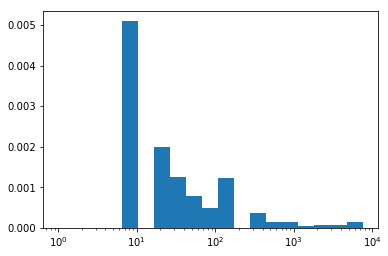

In [295]:
res = runall()

In [296]:
print(datetime.datetime.now().isoformat())

2017-11-09T14:36:08.580698


In [297]:
# 100K lines
# all star ratings are considered watched
# centered the rating data around 0
# lambda = 5e-6
# 10 epochs
res

defaultdict(list, {1e-06: [(0.23959386, 0.98445415)]})

In [213]:
# 1M lines
# all star ratings are considered watched
# centered the rating data around 0
# lambda = 5e-6
# 10 epochs
res

defaultdict(list, {5e-06: [(0.43487486, 0.86346918)]})

Writing to /home/tvromen/research/subtitles2/runs/1510051919

2017-11-07T12:52:01.503558: step 100, loss 0.907448, rating_acc 0.955825->0.952468, rate 0.003
2017-11-07T12:52:03.152124: step 200, loss 0.367514, rating_acc 0.610292->0.605556, rate 0.003
2017-11-07T12:52:04.849260: step 300, loss 2.61865, rating_acc 1.6325->1.61783, rate 0.003
2017-11-07T12:52:06.514451: step 400, loss 0.977994, rating_acc 0.995856->0.987826, rate 0.003
2017-11-07T12:52:08.200116: step 500, loss 1.25621, rating_acc 1.12934->1.11932, rate 0.003
2017-11-07T12:52:09.872983: step 600, loss 0.892536, rating_acc 0.949428->0.942792, rate 0.003
2017-11-07T12:52:11.562449: step 700, loss 0.880012, rating_acc 0.950038->0.935488, rate 0.003
2017-11-07T12:52:13.192748: step 800, loss 0.890135, rating_acc 0.948482->0.940231, rate 0.003
2017-11-07T12:52:14.856940: step 900, loss 0.825631, rating_acc 0.922051->0.904055, rate 0.003
2017-11-07T12:52:15.954127: step 1000, loss 0.864978, rating_acc 0.93941->0.925224, rate 0

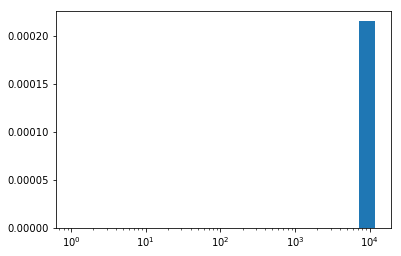

In [215]:
l2_reg_lambda = 5e-6
tf.Graph().as_default()
session_conf = tf.ConfigProto(
    allow_soft_placement=FLAGS.allow_soft_placement,
    log_device_placement=FLAGS.log_device_placement)
session_conf.gpu_options.allow_growth=True
sess = tf.Session(config=session_conf)
sess.as_default()
model = PredictionModel(
    num_users=num_users,
    num_movies=num_movies,
    embedding_dim=FLAGS.embedding_dim,
    l2_reg_lambda=l2_reg_lambda)
last_accuracy = train(model, sess, 3e-3, 20000, 0.5)
mrr, precision_at_10 = calc_precision(model, sess)


In [231]:
ranks = []
mrr = 0
precision_at_10 = 0
n = 500 # calculate only on first n users in validation set
for i in range(n):
    user_id, movie_id, rating = x_val[i]
    if i % 50 == 0:
        print('{}...'.format(i))
    num_movies = ratings.id_assigner.get_next_id()
    batch_movie_id = np.arange(num_movies)
    #batch_user_id = np.ones_like(batch_movie_id) * user_id
    #batch_rating = np.zeros_like(batch_movie_id)
    feed_dict = {
        model.input_user_id: [user_id],
        model.input_movie_id: batch_movie_id,
    }
    scores = sess.run(model.get_predictions(), feed_dict=feed_dict)
    #print(scores)
#         tmp1, tmp2, tmp3 = sess.run([model.tmp1, model.tmp2, model.tmp3], feed_dict=feed_dict)
#         print(tmp1)
#         print(tmp2)
#         print(tmp3)
    s = scores[movie_id] # the score for the correct movie
    #print(s)
    train_movies = x_train[x_train['user_id'] == user_id]['movie_id']
    not_watched = (scores == scores) # all True
    not_watched[train_movies] = False
    higher_scores = (scores > s)    
    rank = np.sum(higher_scores & not_watched) + 1
    ranks.append(rank)
    #print('for user_id {} the rank is {}'.format(user_id, rank))
    mrr += 1. / rank
    if rank <= 10:
        precision_at_10 += 1
    print(rank)
mrr /= n
precision_at_10 /= n
print(mrr)
print(precision_at_10)

0...
11593
817
11536
10822
7
10996
8066
526
10921
604
1197
2709
330
11498
3493
4620
10131
433
8570
7468
538
3016
10058
10747
531
10312
1827
11258
10387
7329
346
622
8681
5682
7637
11453
2626
9797
9097
8467
1905
305
2107
381
9745
392
8621
336
159
2058
50...
11447
10051
521
11205
576
1190
8332
499
430
26
10644
3
294
291
3194
2262
27
10291
11633
1767
4480
272
8840
1343
8410
2754
1
166
8247
430
11
936
2694
694
521
474
989
9330
11583
7735
1062
1769
837
9252
5802
7725
10623
1663
451
4646
100...
10167
90
180
3086
11292
58
1675
11263
8089
8607
2
7145
3207
2526
338
8847
8239
238
1611
2612
354
192
2322
300
11785
2011
8814
11461
9818
8524
8591
10394
1455
4149
9798
1456
10937
46
10558
8586
10131
8228
1504
1026
11061
11277
4890
7634
1674
6675
150...
1665
2705
475
1000
808
971
10912
51
777
9840
162
11096
2815
524
8328
139
1333
149
7646
9159
8876
11551
67
11100
312
7847
1190
323
4148
509
405
554
10544
8285
4063
1524
3378
882
47
3421
6
10690
2494
1460
607
6622
6
9
3022
10674
200...
1193
2741
7232
1
11

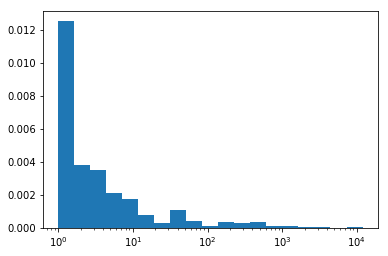

In [232]:
plt.hist(ranks, bins=np.logspace(0., np.log10(ratings.id_assigner.get_next_id()) , 20), normed=1)
plt.gca().set_xscale("log")
plt.show()

In [249]:
for k in range(1, 11):
    print(np.sum([r <= k for r in ranks]))

4
6
8
9
9
11
12
12
14
15


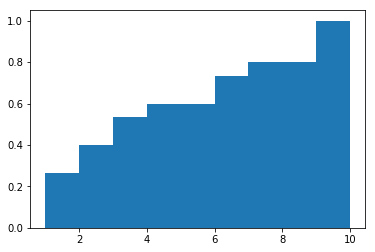

In [253]:
plt.hist(ranks, bins=np.arange(1, 11), normed=1, cumulative=True)
plt.show()

In [254]:
ranks_backup = ranks

In [265]:
# MRR@10
mrr10 = np.mean([(1./r if r <= 10 else 0) for r in ranks_backup])
print(mrr10)

0.0134301587302


In [255]:
# try a naive model - movie bias only

total_watches = np.bincount(x_train['movie_id'])
mean_rating = np.zeros(total_watches.shape)
for i in range(ratings.id_assigner.get_next_id()):
    if i % 500 == 0:
        print('{}...'.format(i))
    t = x_train[x_train['movie_id'] == i]['rating']
    if len(t) > 0:
        mean_rating[i] = np.mean(t)


0...
500...
1000...
1500...
2000...
2500...
3000...
3500...
4000...
4500...
5000...
5500...
6000...
6500...
7000...
7500...
8000...
8500...
9000...
9500...
10000...
10500...
11000...
11500...


In [256]:
# RMSE for the naive model

rmse = 0.
n = 500 # calculate only on first n users in validation set
for i in range(n):
    user_id, movie_id, rating = x_val[i]
    if i % 50 == 0:
        print('{}...'.format(i))
    rmse += (rating - mean_rating[movie_id])**2
rmse /= n
rmse = np.sqrt(rmse)
print(rmse)

0...
50...
100...
150...
200...
250...
300...
350...
400...
450...
0.946751315076


0...
4255
557
1166
1723
31
837
677
51
1021
202
761
34
208
4292
310
1040
1650
78
6796
506
886
481
3647
1535
1501
1486
2258
30
3140
449
690
314
855
352
3204
2113
281
1112
163
487
4269
300
736
108
152
1154
46
270
14
291
50...
852
2
914
4087
681
197
874
978
224
1068
1715
4
212
29
6288
376
7
1332
344
1712
6320
223
1831
679
144
131
14
53
3363
305
6
2215
125
196
2152
291
2
1093
2048
312
255
1662
140
3592
647
2236
1025
358
391
7
100...
1415
759
357
75
893
474
2617
2388
296
21
9
273
828
3796
98
3742
227
269
651
7
597
1090
785
280
4365
364
1713
168
3797
349
5730
5467
147
1657
2430
1675
1133
265
2079
825
106
1107
888
4483
740
178
188
752
60
271
150...
277
178
465
2658
16
49
941
74
5
3094
1422
3620
294
212
4979
9
174
425
167
1812
366
222
118
2866
342
2383
76
2247
3410
51
58
727
1821
6658
16
252
1885
457
14
333
14
3033
314
64
1457
502
165
27
4847
184
200...
148
3300
307
13
108
26
106
1194
3505
1603
427
1
1083
27
2070
353
2300
2792
418
389
3
643
410
4494
214
92
435
1358
1143
644
88
35
511
346
47
200

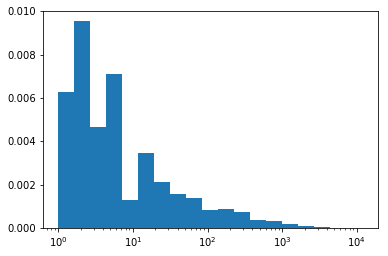

In [258]:
# MRR for the naive model

ranks = []
mrr = 0
precision_at_10 = 0
n = 500 # calculate only on first n users in validation set
for i in range(n):
    user_id, movie_id, rating = x_val[i]
    if i % 50 == 0:
        print('{}...'.format(i))
    scores = total_watches
    s = scores[movie_id] # the score for the correct movie
    train_movies = x_train[x_train['user_id'] == user_id]['movie_id']
    not_watched = (scores == scores) # all True
    not_watched[train_movies] = False
    higher_scores = (scores > s)    
    rank = np.sum(higher_scores & not_watched) + 1
    ranks.append(rank)
    mrr += 1. / rank
    if rank <= 10:
        precision_at_10 += 1
    print(rank)
mrr /= n
precision_at_10 /= n
print(mrr)
print(precision_at_10)
plt.hist(ranks, bins=np.logspace(0., np.log10(ratings.id_assigner.get_next_id()) , 20), normed=1)
plt.gca().set_xscale("log")
plt.show()

In [260]:
for k in range(1, 11):
    print(np.sum([r <= k for r in ranks]))

2
7
9
11
13
16
21
21
23
24


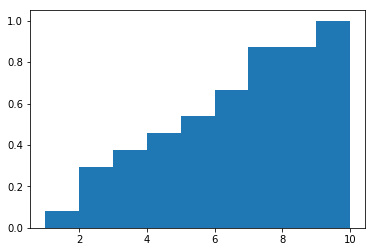

In [261]:
plt.hist(ranks, bins=np.arange(1, 11), normed=1, cumulative=True)
plt.show()

In [266]:
# MRR@10
mrr10 = np.mean([(1./r if r <= 10 else 0) for r in ranks])
print(mrr10)

0.0152063492063


In [81]:
# 1M lines
# all star ratings are considered watched
# centered the rating data around 0
# lambda = 5e-6
# 10 epochs
res

defaultdict(list, {5e-06: [(0.49899518, 0.88868439)]})

In [76]:
# 1M lines
# all star ratings are considered watched
# added regularization with various lambda values
# centered the rating data around 0
res

defaultdict(list,
            {1e-05: [(0.94917321, 0.90415049)],
             2e-05: [(1.0507183, 0.94094837)],
             5e-05: [(1.1423631, 0.99971867)],
             0.0001: [(1.2070471, 1.0341849)],
             0.0002: [(1.2103031, 1.032499)],
             0.0005: [(1.2117321, 1.031128)],
             0.001: [(1.211888, 1.0307046)]})

In [73]:
# 1M lines
# all star ratings are considered watched
# added regularization with various lambda values
# centered the rating data around 0
res

defaultdict(list,
            {0.0: [(0.37671992, 1.0658302)],
             1e-06: [(0.52806127, 0.92396885)],
             2e-06: [(0.61344689, 0.91350502)],
             5e-06: [(0.79430443, 0.8886568)]})

In [64]:
# 1M lines
# all star ratings are considered watched
# added regularization with various lambda values
res

defaultdict(list,
            {1e-06: [(0.66761941, 0.94619572)],
             5e-06: [(0.86379659, 0.98251671)]})

In [61]:
# 1M lines
# all star ratings are considered watched
# added regularization with various lambda values
res

defaultdict(list,
            {2e-06: [(0.74221069, 0.94485837)],
             2e-05: [(1.0187515, 1.1469429)]})

In [58]:
# 1M lines
# all star ratings are considered watched
# added regularization with various lambda values
res

defaultdict(list,
            {0.0: [(0.39927015, 1.0191419)],
             0.0001: [(1.2529024, 1.5867586)],
             0.0002: [(1.3900354, 1.8572755)],
             0.0005: [(1.6396413, 2.2380252)],
             0.001: [(1.9155307, 2.5586977)],
             0.002: [(2.2482929, 2.8847487)],
             0.005: [(2.6905251, 3.2657373)],
             0.01: [(2.9629481, 3.4821424)],
             0.02: [(3.1559427, 3.6294582)],
             0.05: [(3.3028438, 3.7391768)],
             0.1: [(3.3588696, 3.7807691)]})

In [38]:
# 1M lines
# all star ratings are considered watched
# added regularization (0.01)
res

defaultdict(list, {0: [(2.9629481, 3.4821424)]})

In [33]:
# 1M lines
# all star ratings are considered watched
# added regularization (0.1)
res

defaultdict(list, {0: [(3.3588698, 3.7807691)]})

In [20]:
# 1M lines
# all star ratings are considered watched
res

defaultdict(list, {0: [(0.41014692, 1.0094724)]})